In [1]:
!nvidia-smi

Wed Mar  2 04:22:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive # Import a library named google.colab
drive.mount('/content/drive', force_remount=True) # mount the content to the directory `/content/drive`
%cd /content/drive/MyDrive 
%cd Bert

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/Bert


## 1. Install requirement

In [ ]:
!pip install tensorflow_text

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import keras

## 2.Read data and do data cleaning

In [5]:
df = pd.read_csv("Fake_News_Dataset/train.csv")
df.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
df=df.dropna()

In [7]:
df.groupby('label').describe()

id                             ...                           
         count          mean          std  ...      50%      75%      max
label                                      ...                           
0      10361.0  10391.956954  5981.636938  ...  10395.0  15564.0  20797.0
1       7924.0  10433.147653  6020.123501  ...  10443.5  15655.5  20799.0

[2 rows x 8 columns]

## 3.Create training data and testing data

In [8]:
df_true = df[df['label']==0]
df_true.shape

(10361, 5)

In [9]:
df_fake = df[df['label']==1]
df_fake.shape

(7924, 5)

In [10]:
df_true_downsampled = df_true.sample(df_fake.shape[0])
df_true_downsampled.shape

(7924, 5)

In [11]:
df_balanced = pd.concat([df_true_downsampled, df_fake])
df_balanced.shape

(15848, 5)

In [12]:
df_balanced['label'].value_counts()

0    7924
1    7924
Name: label, dtype: int64

In [13]:
df_balanced.columns

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')

In [14]:
from sklearn.model_selection import train_test_split
# stratify means you can split data with portion
X_train, X_test, y_train, y_test = train_test_split(df_balanced['title'],df_balanced['label'], train_size=0.9 , stratify=df_balanced['label'])

## 4.Choose Bert model from tensorflow hub 

In [29]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1, name='dropout')(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)


In [30]:
model = build_classifier_model()

## 5.Plot model architecture

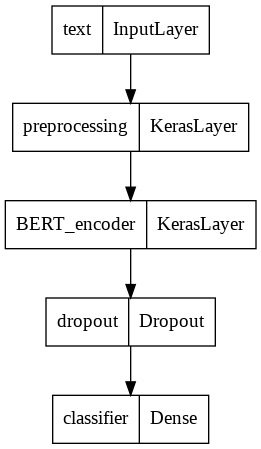

In [31]:
tf.keras.utils.plot_model(model)

## 6.Train the model

In [49]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy(name='accuracy'))

In [68]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
446/446 [==============================] - 406s 909ms/step - loss: 0.3560 - accuracy: 0.8555 - val_loss: 0.3395 - val_accuracy: 0.8562
Epoch 2/5
446/446 [==============================] - 396s 888ms/step - loss: 0.3439 - accuracy: 0.8580 - val_loss: 0.3286 - val_accuracy: 0.8694
Epoch 3/5
446/446 [==============================] - 395s 886ms/step - loss: 0.3357 - accuracy: 0.8625 - val_loss: 0.3216 - val_accuracy: 0.8763
Epoch 4/5
446/446 [==============================] - 395s 885ms/step - loss: 0.3286 - accuracy: 0.8629 - val_loss: 0.3199 - val_accuracy: 0.8801
Epoch 5/5
446/446 [==============================] - 395s 886ms/step - loss: 0.3256 - accuracy: 0.8648 - val_loss: 0.3115 - val_accuracy: 0.8808


## 7.Plot the training process

In [53]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


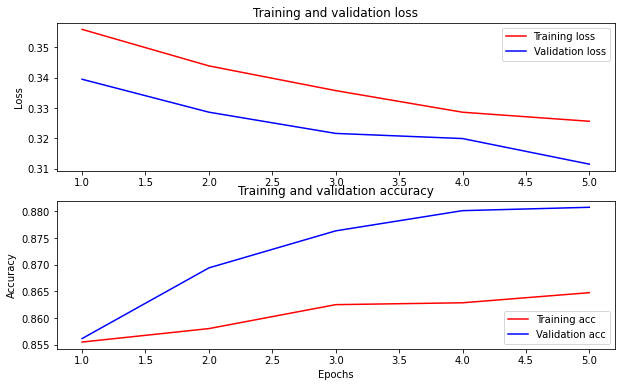

In [69]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## 8.Save the model

In [70]:
!mkdir -p saved_model
model.save('saved_model/Fake-News-Detection-Model-With-Bert')

INFO:tensorflow:Assets written to: saved_model/Fake-News-Detection-Model-With-Bert/assets


INFO:tensorflow:Assets written to: saved_model/Fake-News-Detection-Model-With-Bert/assets
